In [1]:
# How can we get a clean dataset of COVID deaths in WI?
import os
import pandas as pd
import geopandas as gpd

if not os.path.exists("covid.geojson"):
    print("DOWNLOAD")
    url = "https://opendata.arcgis.com/datasets/559d482bad0643f69cbe1538243e0baa_9.geojson"
    df = gpd.read_file(url)
    df.to_file("covid.geojson", index=False)
    
df = gpd.read_file("covid.geojson")

<AxesSubplot:>

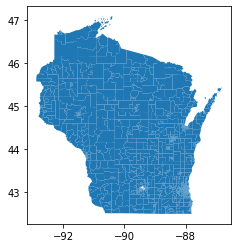

In [2]:
df.plot()

In [3]:
# POP, POS_CUM_CP, POS_???_???_CP, DTH_CUM_CP
df.columns

Index(['RptDt', 'GEOID', 'GEOName', 'POS_CUM_CP', 'POS_NEW_CP',
       'POS_7DAYAVG_CP', 'DTH_CUM_CP', 'DTH_NEW_CP', 'DTH_7DAYAVG_CP',
       'DTH_OVER_30DAYS_CP', 'DTH_CP_Daily', 'NEG_CUM', 'NEG_NEW',
       'NEG_7DAYAVG', 'TESTS_CUM', 'TESTS_NEW', 'TESTS_7DAYAVG',
       'POS_CUM_CONF', 'POS_NEW_CONF', 'POS_7DAYAVG_CONF', 'POS_CUM_PROB',
       'POS_NEW_PROB', 'POS_7DAYAVG_PROB', 'DTH_CUM_CONF', 'DTH_NEW_CONF',
       'DTH_7DAYAVG_CONF', 'DTH_CONF_Daily', 'DTH_CUM_PROB', 'DTH_NEW_PROB',
       'DTH_7DAYAVG_PROB', 'DTH_PROB_Daily', 'POS_MALE_CP', 'POS_FEM_CP',
       'POS_OTH_CP', 'POS_0_9_CP', 'POS_10_19_CP', 'POS_20_29_CP',
       'POS_30_39_CP', 'POS_40_49_CP', 'POS_50_59_CP', 'POS_60_69_CP',
       'POS_70_79_CP', 'POS_80_89_CP', 'POS_90_CP', 'DTHS_FEM_CP',
       'DTHS_MALE_CP', 'DTHS_OTH_CP', 'DTHS_0_9_CP', 'DTHS_10_19_CP',
       'DTHS_20_29_CP', 'DTHS_30_39_CP', 'DTHS_40_49_CP', 'DTHS_50_59_CP',
       'DTHS_60_69_CP', 'DTHS_70_79_CP', 'DTHS_80_89_CP', 'DTHS_90_CP',
       'PO

In [4]:
df = df.replace(-999, 2) # -999 means 0-4 (based on docs)
df = df[df["GEOID"].str.fullmatch("\d+")] # (based on looking for weird data)

<AxesSubplot:xlabel='POP', ylabel='DTH_CUM_CP'>

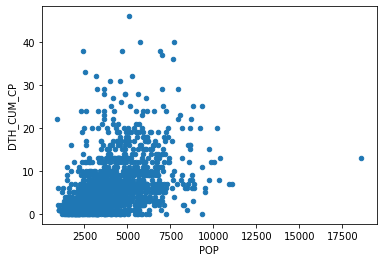

In [5]:
df.plot.scatter(x="POP", y="DTH_CUM_CP")

In [6]:
df.sort_values(by="POP", ascending=True).head()

,RptDt,GEOID,GEOName,POS_CUM_CP,POS_NEW_CP,POS_7DAYAVG_CP,DTH_CUM_CP,DTH_NEW_CP,DTH_7DAYAVG_CP,DTH_OVER_30DAYS_CP,...,HOSP_NO_CP,HOSP_UNK_CP,Date,POP,POP_MOE,OBJECTID,GEO,ShapeSTArea,ShapeSTLength,geometry
622,2021-11-12T20:00:00+00:00,55101980000,None,352,0,1.14,22,0,0.14,0,...,118,208,2021-11-11T00:00:00+00:00,902,375.0,2280,Census tract,4.475156e+06,8427.329014,"POLYGON ((-88.07100 42.68608, -88.07111 42.686..."
1239,2021-11-12T20:00:00+00:00,55079185900,None,239,1,0.29,6,0,0.00,0,...,148,74,2021-11-11T00:00:00+00:00,980,178.0,3018,Census tract,9.038821e+05,4168.783297,"POLYGON ((-87.92700 43.05655, -87.92728 43.056..."
320,2021-11-12T20:00:00+00:00,55079008400,None,145,1,0.29,2,0,0.00,0,...,83,44,2021-11-11T00:00:00+00:00,984,156.0,1248,Census tract,8.559978e+05,3755.846520,"POLYGON ((-87.92399 43.07121, -87.92415 43.071..."
322,2021-11-12T20:00:00+00:00,55079008600,None,163,2,0.57,1,0,0.00,0,...,104,42,2021-11-11T00:00:00+00:00,999,156.0,1250,Census tract,5.662337e+05,3317.907993,"POLYGON ((-87.93321 43.07139, -87.93344 43.071..."
628,2021-11-12T20:00:00+00:00,55105000100,None,93,1,0.43,1,0,0.00,0,...,63,24,2021-11-11T00:00:00+00:00,1005,131.0,2286,Census tract,1.190527e+06,5166.513641,"POLYGON ((-89.01865 42.68531, -89.01829 42.686..."


In [7]:
# How can we train/fit models to known data to predict unknowns?
# Population => Deaths, Cases => Deaths, Cases (by age) => Deaths

In [8]:
# sklearn models want a DataFrame (or something like it) for x values
xcols = ["POP"]
df[xcols].head()

,POP
0,2243
1,5217
2,6787
3,3493
4,1463


In [9]:
# sklearn models want a Series (or something like it) for y values
ycol = "DTH_CUM_CP"
df[ycol].head()

0     0
1     6
2    19
3     7
4     0
Name: DTH_CUM_CP, dtype: int64

In [10]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(df[xcols], df[ycol]) # training

predict_df = pd.DataFrame({
    "POP": range(0, 20000, 1000)
})
predict_df["predicted_death"] = model.predict(predict_df[xcols])
predict_df.head()

# TODO: test it against a training dataset

,POP,predicted_death
0,0,1.182903
1,1000,2.525213
2,2000,3.867524
3,3000,5.209834
4,4000,6.552145


In [11]:
# How can we visualize model predictions?

<AxesSubplot:xlabel='POP', ylabel='DTH_CUM_CP'>

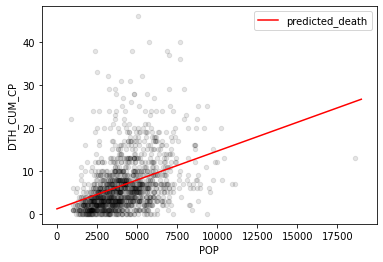

In [12]:
ax = predict_df.plot.line(x="POP", y="predicted_death", color="red")
df.plot.scatter(x="POP", y="DTH_CUM_CP", ax=ax, color="black", alpha=0.1)

In [20]:
# How can we get a formula for the relationship?

In [23]:
slope = model.coef_[0]
slope

0.0013423105598069026

In [24]:
model.intercept_

1.1829028125539898

In [25]:
f"deaths = {slope} * population + {model.intercept_}"

'deaths = 0.0013423105598069026 * population + 1.1829028125539898'

In [14]:
# How well does our model fit the data?

In [28]:
before = df[ycol].var()
before

39.239011357908396

In [33]:
residuals = model.predict(df[xcols]) - df[ycol]
after = residuals.var()
after

33.743878062863864

In [35]:
# r^2 score, "explained variance"
improvement = before - after
improvement / before

0.14004260313599923

In [36]:
model.score(df[xcols], df[ycol])

0.14004260313599926

In [60]:
# Did our model learn or memorize (that is, "overfit")?

from sklearn.model_selection import train_test_split, cross_val_score

#train = df.iloc[:len(df)//2]
#test = df.iloc[len(df)//2:]

# (1) randomly shuffle order of df (2) split 75%/25% (default) across train/test DataFrames
train, test = train_test_split(df)
len(train), len(test)

(1044, 348)

In [70]:
model = LinearRegression()
model.fit(train[xcols], train[ycol]) # learning
model.score(test[xcols], test[ycol]) # how good is it?

0.14746715597220272

In [68]:
# How can we minimize noise due to random train/test splits?

# loop 5 times, each time fit/score the model on a different train/test combo
# return an array of all the scores
scores = cross_val_score(model, train[xcols], train[ycol], cv=8)
scores

array([-0.01941784,  0.21873093,  0.17220775,  0.18562749,  0.1231954 ,
        0.10952704,  0.08887222,  0.09825141])

In [71]:
scores.mean(), scores.std()  # average, standard devation of scores

(0.12212429748398498, 0.06868722524803568)

In [72]:
# How can we compare models?
xcols2 = ["POS_CUM_CP"]
model2 = LinearRegression()
scores2 = cross_val_score(model2, train[xcols2], train[ycol], cv=8)
scores2

array([0.01882576, 0.31512853, 0.25977176, 0.25210125, 0.13130535,
       0.17383335, 0.12947358, 0.18976645])

In [73]:
scores2.mean()

0.18377575333684848

In [79]:
# to compare: want a bar plot where y axis is explained variance
compare = pd.DataFrame({
    "scores": {"LinReg (Pop)": scores.mean(), "LinReg (Cases)": scores2.mean()},
    "std_dev": {"LinReg (Pop)": scores.std(), "LinReg (Cases)": scores2.std()}
})
compare

,scores,std_dev
LinReg (Pop),0.122124,0.068687
LinReg (Cases),0.183776,0.087137


Text(0, 0.5, 'Explained Variance (Deaths)')

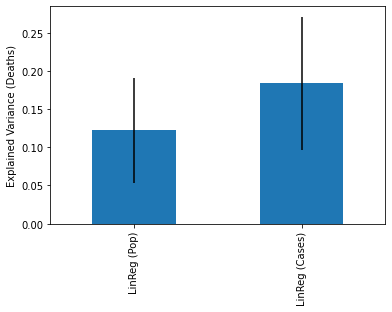

In [80]:
ax = compare["scores"].plot.bar(yerr=compare["std_dev"])
ax.set_ylabel("Explained Variance (Deaths)")

In [81]:
train.columns

Index(['RptDt', 'GEOID', 'GEOName', 'POS_CUM_CP', 'POS_NEW_CP',
       'POS_7DAYAVG_CP', 'DTH_CUM_CP', 'DTH_NEW_CP', 'DTH_7DAYAVG_CP',
       'DTH_OVER_30DAYS_CP', 'DTH_CP_Daily', 'NEG_CUM', 'NEG_NEW',
       'NEG_7DAYAVG', 'TESTS_CUM', 'TESTS_NEW', 'TESTS_7DAYAVG',
       'POS_CUM_CONF', 'POS_NEW_CONF', 'POS_7DAYAVG_CONF', 'POS_CUM_PROB',
       'POS_NEW_PROB', 'POS_7DAYAVG_PROB', 'DTH_CUM_CONF', 'DTH_NEW_CONF',
       'DTH_7DAYAVG_CONF', 'DTH_CONF_Daily', 'DTH_CUM_PROB', 'DTH_NEW_PROB',
       'DTH_7DAYAVG_PROB', 'DTH_PROB_Daily', 'POS_MALE_CP', 'POS_FEM_CP',
       'POS_OTH_CP', 'POS_0_9_CP', 'POS_10_19_CP', 'POS_20_29_CP',
       'POS_30_39_CP', 'POS_40_49_CP', 'POS_50_59_CP', 'POS_60_69_CP',
       'POS_70_79_CP', 'POS_80_89_CP', 'POS_90_CP', 'DTHS_FEM_CP',
       'DTHS_MALE_CP', 'DTHS_OTH_CP', 'DTHS_0_9_CP', 'DTHS_10_19_CP',
       'DTHS_20_29_CP', 'DTHS_30_39_CP', 'DTHS_40_49_CP', 'DTHS_50_59_CP',
       'DTHS_60_69_CP', 'DTHS_70_79_CP', 'DTHS_80_89_CP', 'DTHS_90_CP',
       'PO

In [83]:
# How can we use multiple x variables (multiple regression)?
xcols3 = ['POS_0_9_CP', 'POS_10_19_CP', 'POS_20_29_CP',
       'POS_30_39_CP', 'POS_40_49_CP', 'POS_50_59_CP', 'POS_60_69_CP',
       'POS_70_79_CP', 'POS_80_89_CP', 'POS_90_CP']
model3 = LinearRegression()
scores3 = cross_val_score(model3, train[xcols3], train[ycol], cv=8)
scores3.mean()

0.6396965146467173

In [19]:
# How can we interpret what features the model is relying on?

In [86]:
model3.fit(train[xcols3], train[ycol])
model3.coef_

array([-0.01725737, -0.00340641,  0.00137341,  0.0092049 ,  0.024102  ,
       -0.01817404, -0.00693848,  0.03043993,  0.18933469,  0.30993207])

<AxesSubplot:>

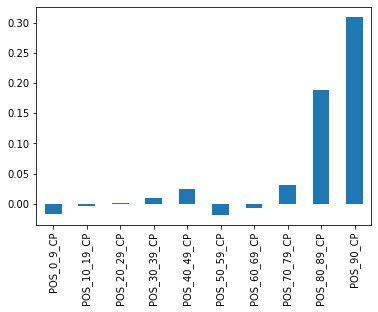

In [88]:
pd.Series(model3.coef_, index=xcols3).plot.bar()